<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/CP%20CPMG%20UDD%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 30.7 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#6. Pulse Shaping

### 1) Single $ \pi $ Envelope

In [3]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

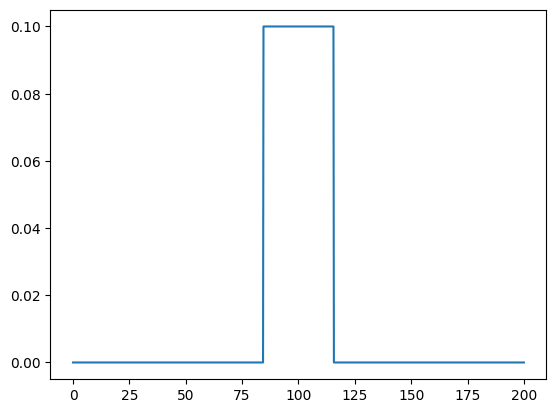

In [4]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Square(tlist, {'A': 0.1}, 100))

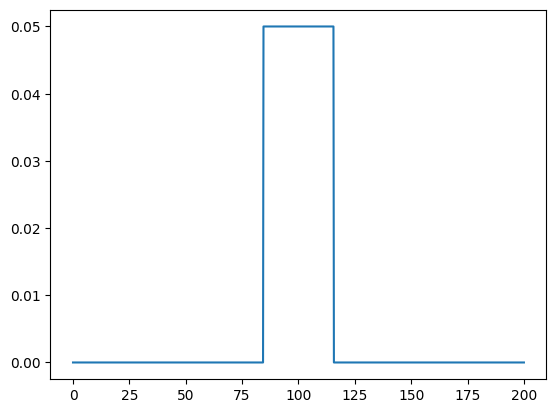

In [5]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Square(tlist, {'A': 0.1}, 100))

In [6]:
# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

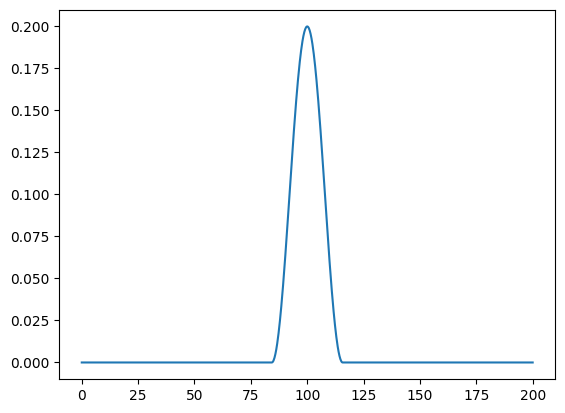

In [7]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Cosine(tlist, {'A': 0.1}, 100))

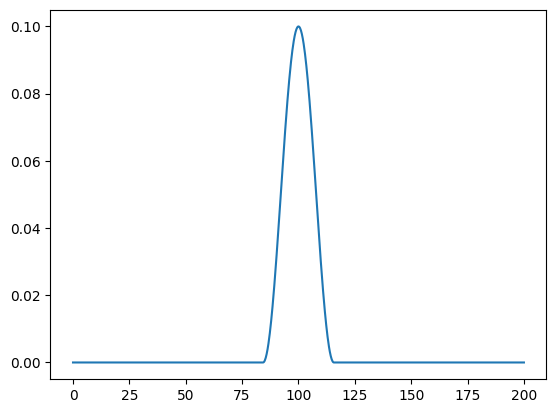

In [8]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Cosine(tlist, {'A': 0.1}, 100))

In [9]:
# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

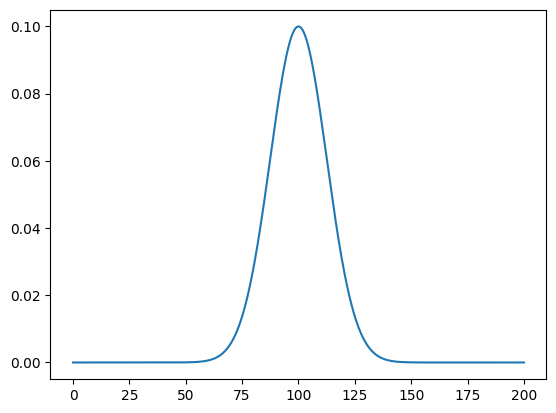

In [10]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Gaussian(tlist, {'A': 0.1}, 100))

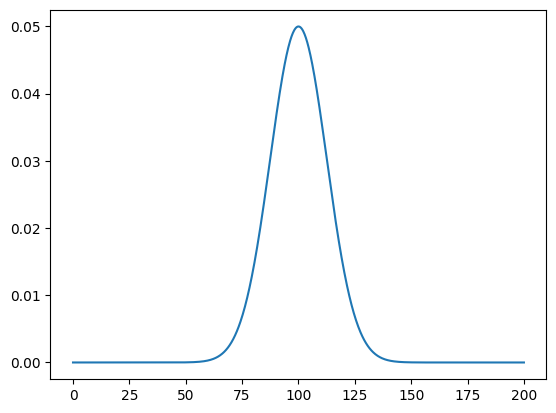

In [11]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Gaussian(tlist, {'A': 0.1}, 100))

### 2) Single $ \pi $ Pulse

In [12]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

In [13]:
# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    f2 = np.vectorize(f)

    return f2(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

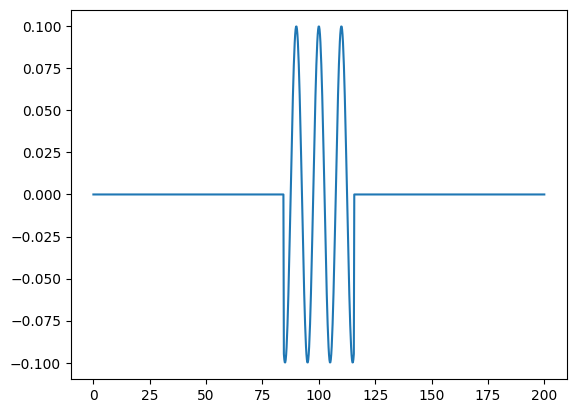

In [14]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(0, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.1, 'Phi': 0}, 100))

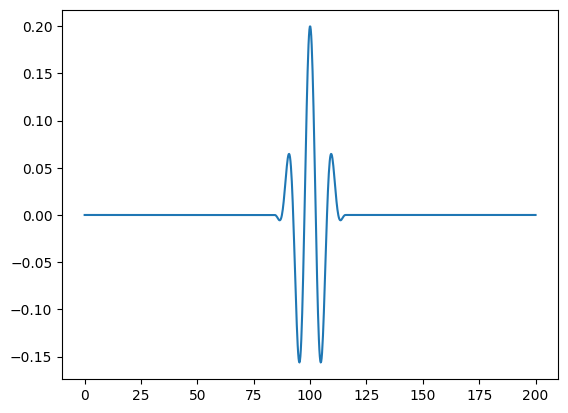

In [15]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(1, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.1, 'Phi': 0}, 100))

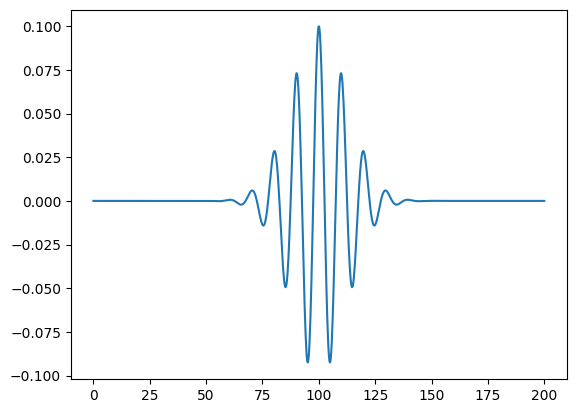

In [16]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(2, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.1, 'Phi': 0}, 100))

### 3) Pulse Shaping Function

In [17]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [18]:
Pulse_Timing(0, 200, 10, 0)

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190.])

In [19]:
Pulse_Timing(100, 300, 10, 2)

array([106.81483474, 119.9800845 , 138.59855926, 161.40144074,
       186.83475024, 213.16524976, 238.59855926, 261.40144074,
       280.0199155 , 293.18516526])

In [20]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    # CPMG
    elif (Func==1) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    # UDD
    elif (Func==2) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [21]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': A}, T_end)

    return pulse

### 4) Visualize Ramsey & Spin Echo Pulse (Lab Frame)

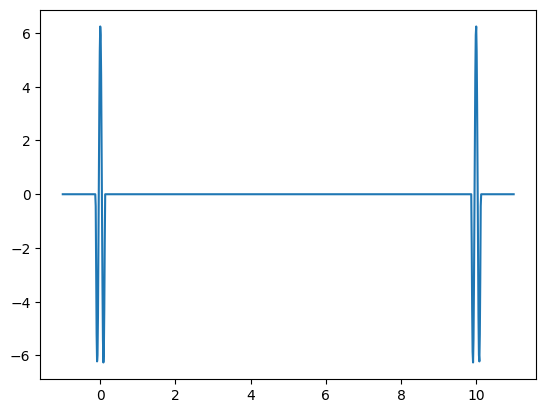

In [22]:
# Ramsey
# Square Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0}))

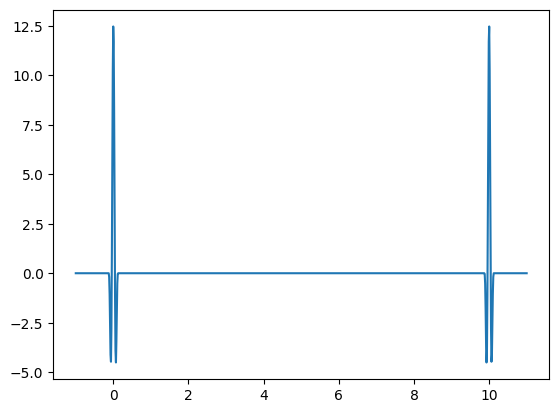

In [23]:
# Ramsey
# Cosine Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 1, 'Func': 0}))

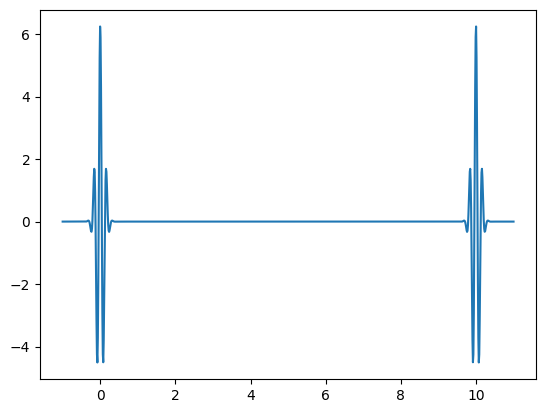

In [24]:
# Ramsey
# Gaussian Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 2, 'Func': 0}))

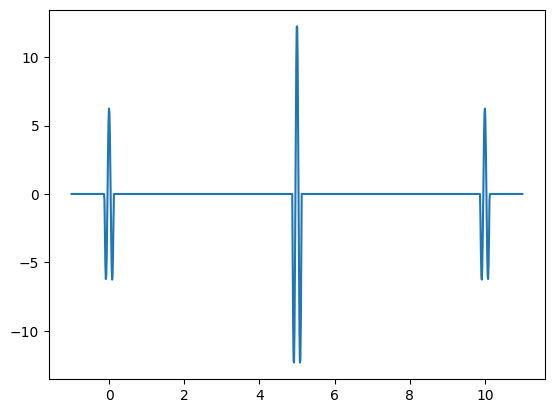

In [25]:
# Spin Echo
# Square Pulse
# X Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0}))

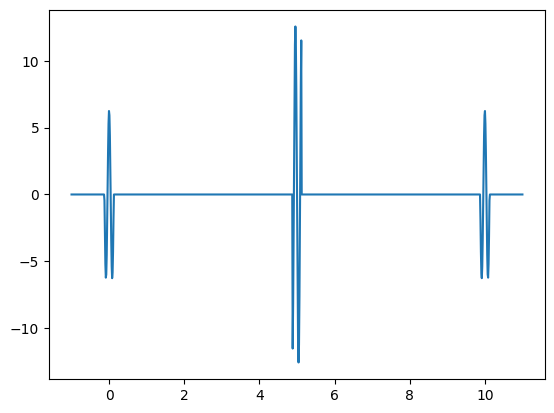

In [26]:
# Spin Echo
# Square Pulse
# Y Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 1}))

### 5) Visualize CP Pulse (Lab Frame)

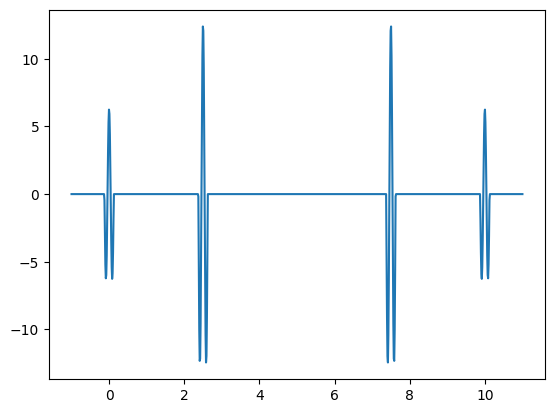

In [27]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 0}))

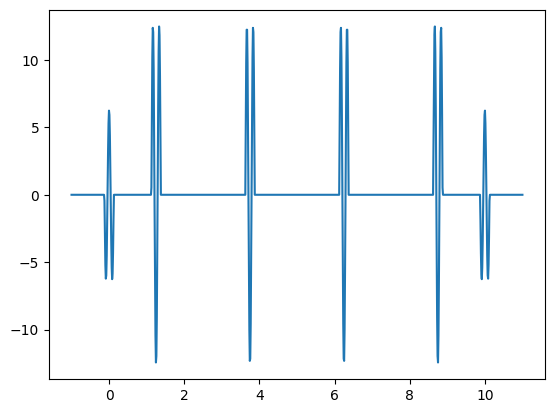

In [28]:
# CP
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 0}))

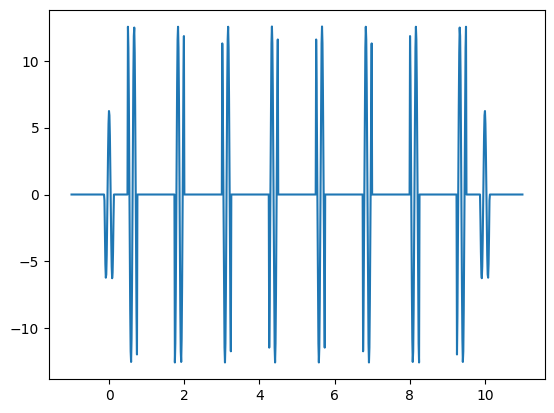

In [29]:
# CP
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 0}))

### 6) Visualize CPMG Pulse (Lab Frame)

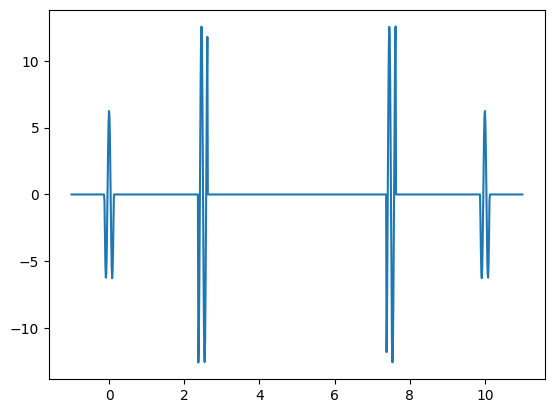

In [30]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 1}))

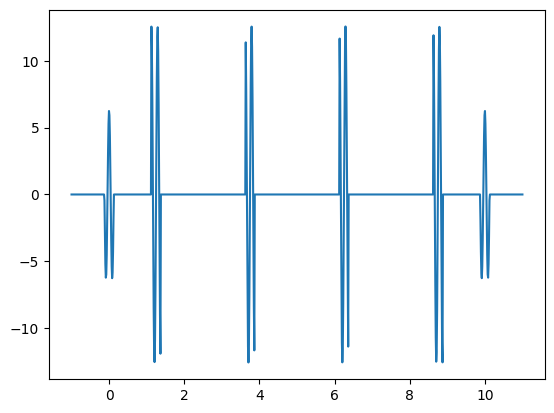

In [31]:
# CPMG
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 1}))

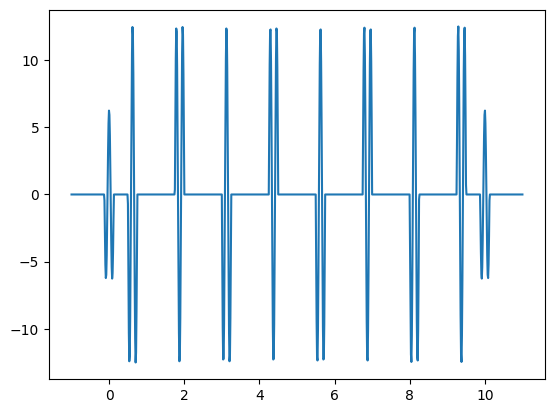

In [32]:
# CPMG
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 1}))

### 7) Visualize UDD Pulse (Lab Frame)

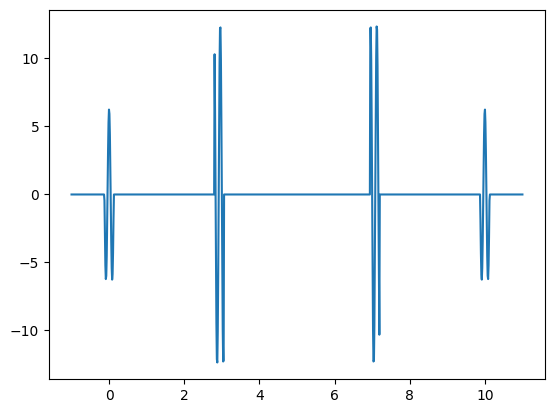

In [33]:
# UDD
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 2}))

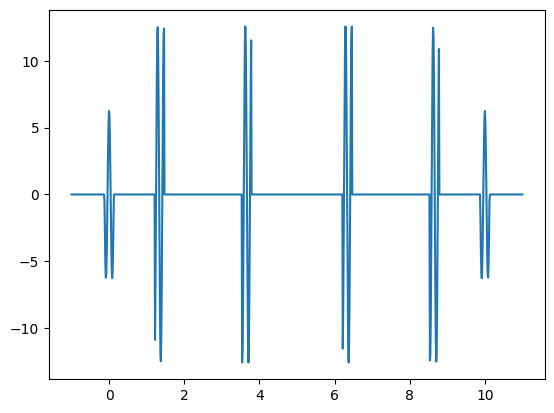

In [34]:
# UDD
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 2}))

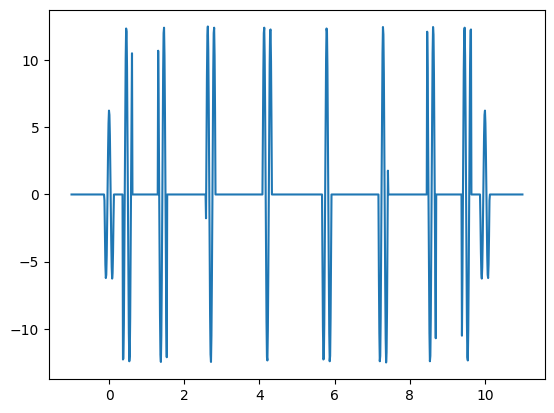

In [35]:
# UDD
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 2}))

### 8) Visualize Ramsey & Spin Echo Pulse (Rotating Frame)

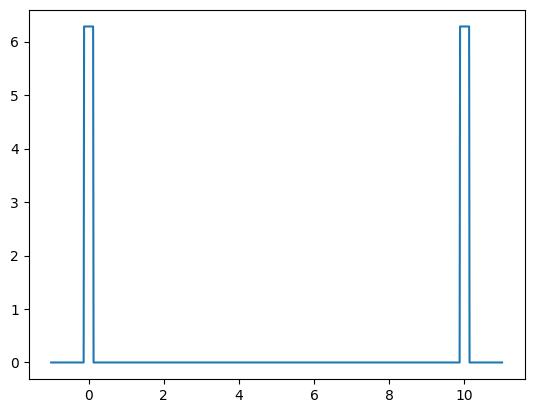

In [36]:
# Ramsey
# Square Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0}))

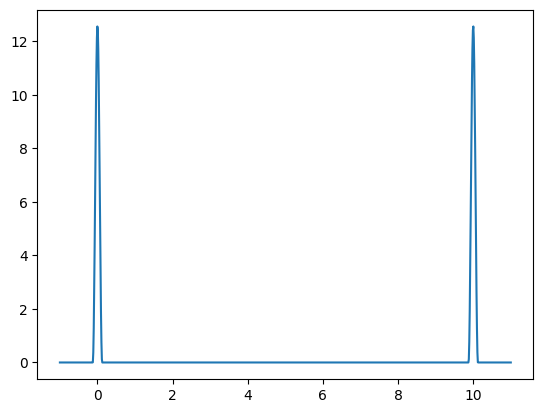

In [37]:
# Ramsey
# Cosine Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 1, 'Func': 0}))

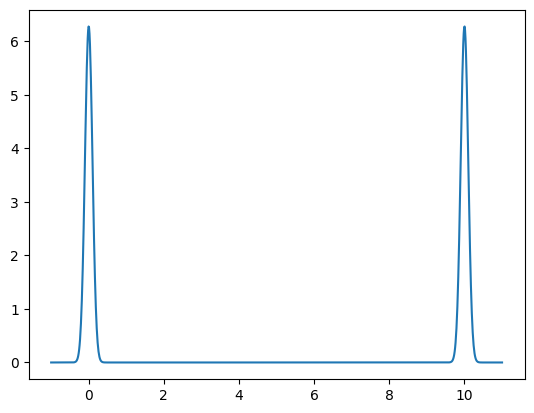

In [38]:
# Ramsey
# Gaussian Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 2, 'Func': 0}))

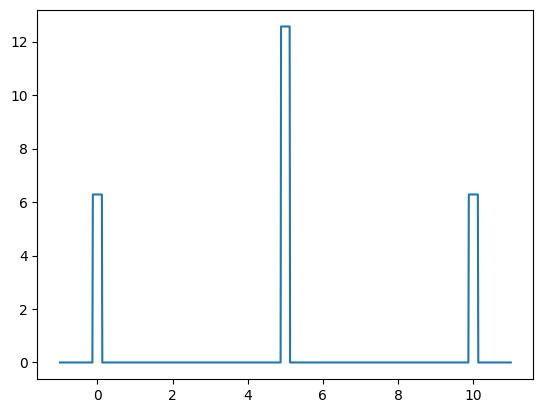

In [39]:
# Spin Echo
# Square Pulse
# X Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0}))

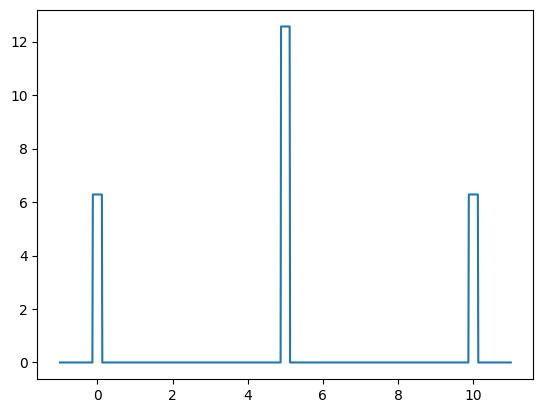

In [40]:
# Spin Echo
# Square Pulse
# Y Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 1}))

### 9) Visualize CP Pulse (Rotating Frame)

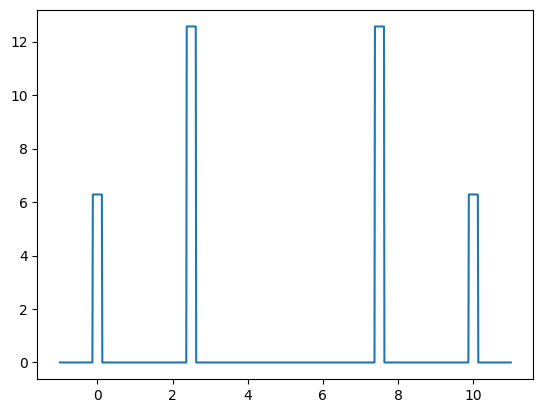

In [41]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 0}))

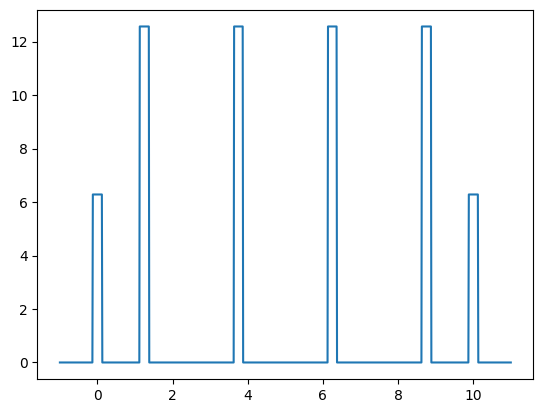

In [42]:
# CP
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 0}))

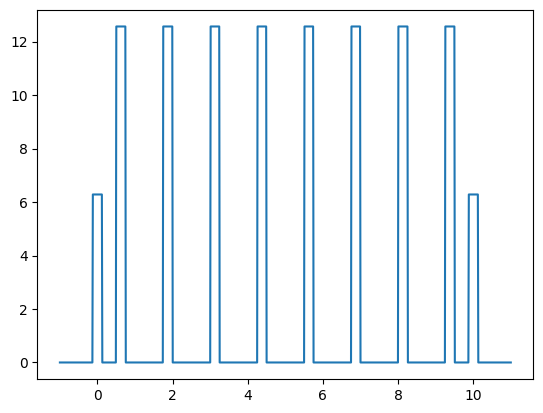

In [43]:
# CP
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 0}))

### 10) Visualize CPMG Pulse (Rotating Frame)

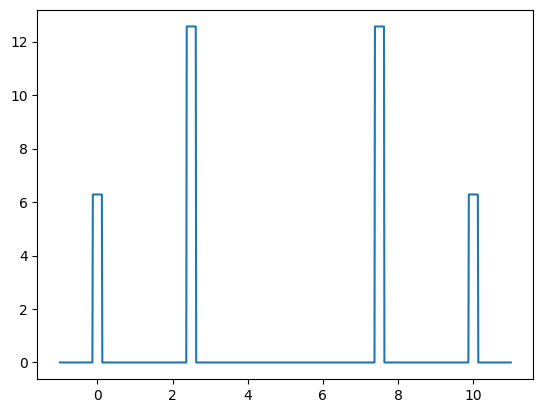

In [44]:
# CPMG
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 1}))

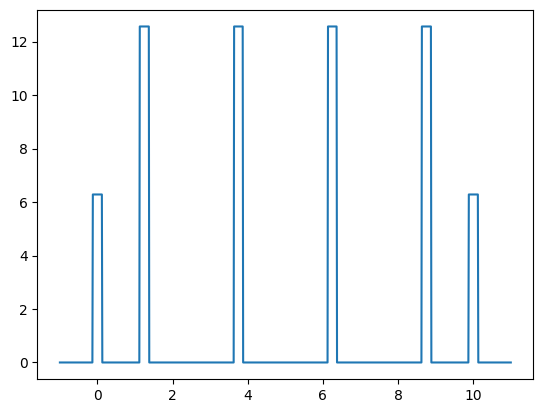

In [45]:
# CPMG
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 1}))

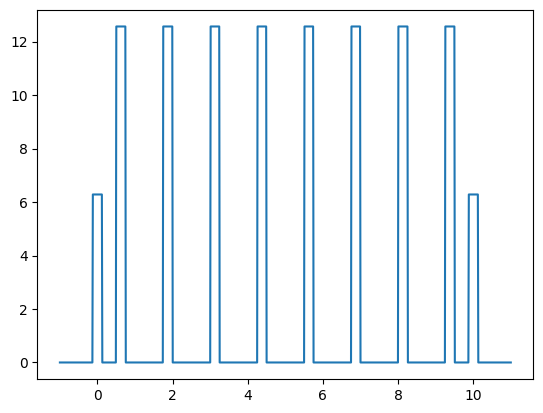

In [46]:
# CPMG
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 1}))

### 11) Visualize UDD Pulse (Rotating Frame)

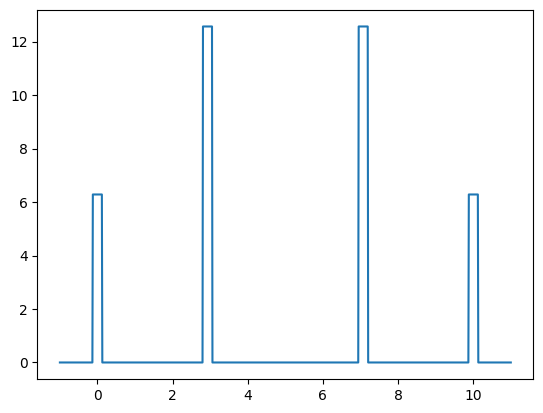

In [47]:
# UDD
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 2}))

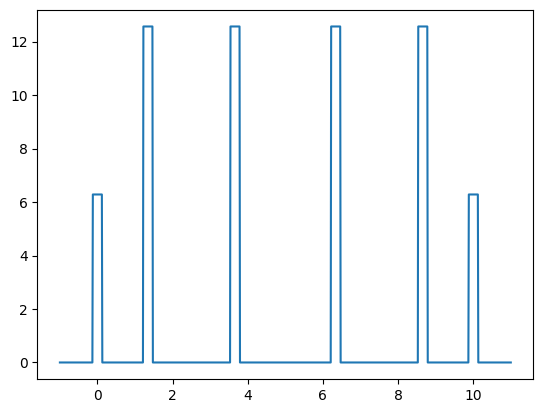

In [48]:
# UDD
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 2}))

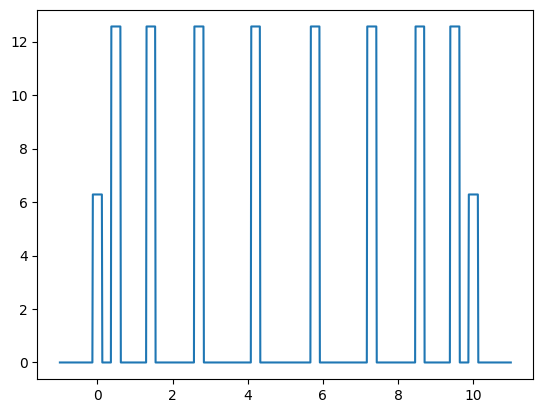

In [49]:
# UDD
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 2}))

### 12) Qubit not coupled with Resonator (Lab Frame)

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [50]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rd = 2 * np.pi * 6.0  # qubit frequency in units of GHz

In [51]:
# operator

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

### 13) Ramsey : Varying Amplitude

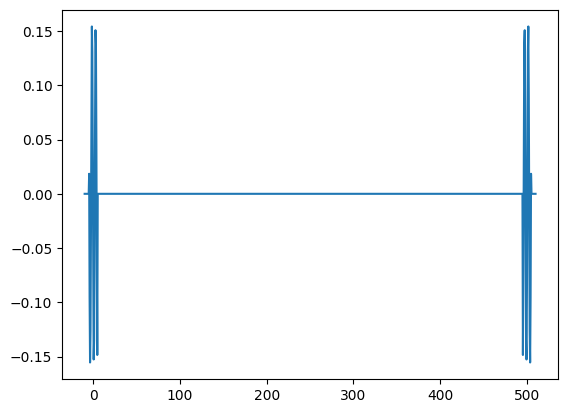

In [163]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.05

tlist = np.linspace(-10,510,1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [164]:
tlist = np.linspace(-10,510,10000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

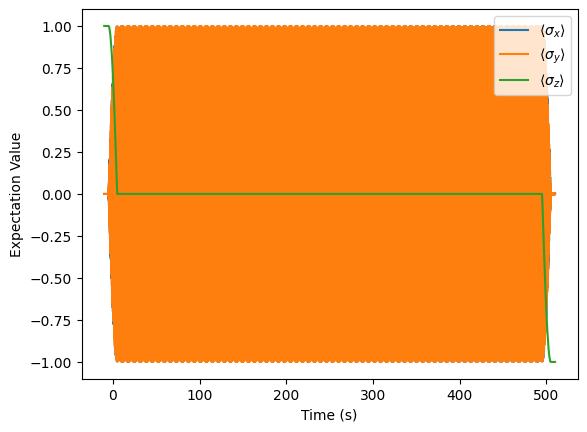

In [165]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

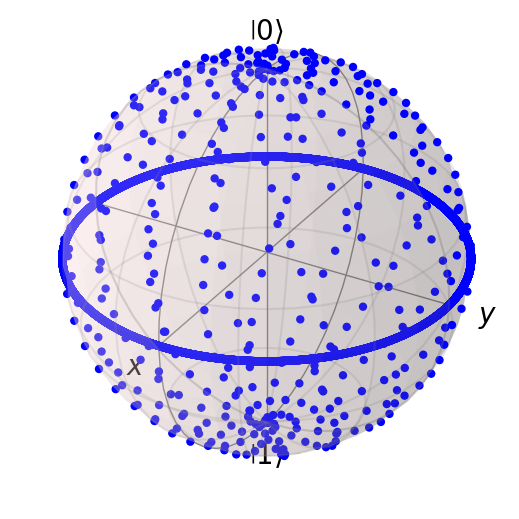

In [166]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

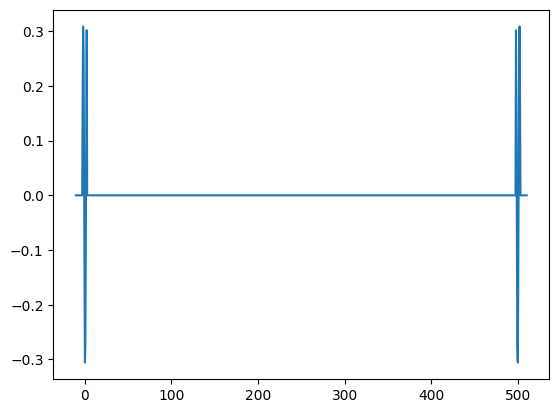

In [167]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.1

tlist = np.linspace(-10,510,1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [168]:
tlist = np.linspace(-10,510,10000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

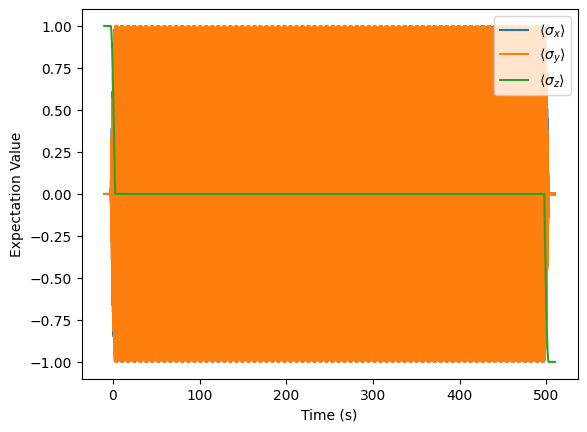

In [169]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

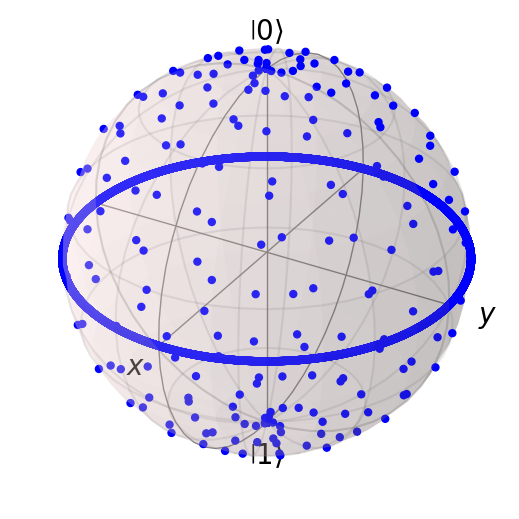

In [170]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

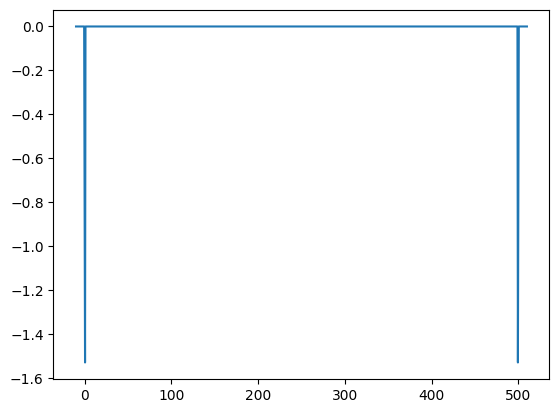

In [173]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.5

tlist = np.linspace(-10,510,1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.5, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [174]:
tlist = np.linspace(-10,510,10000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.5, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

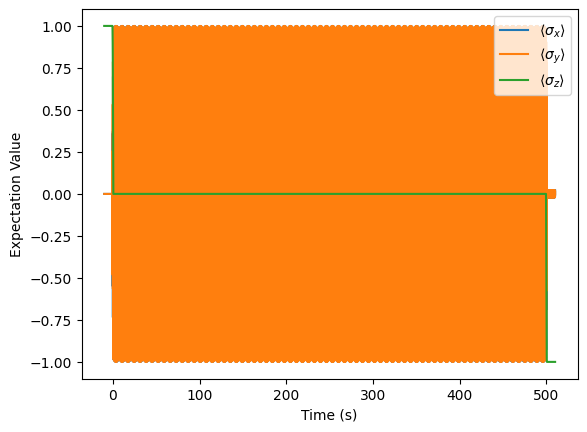

In [175]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

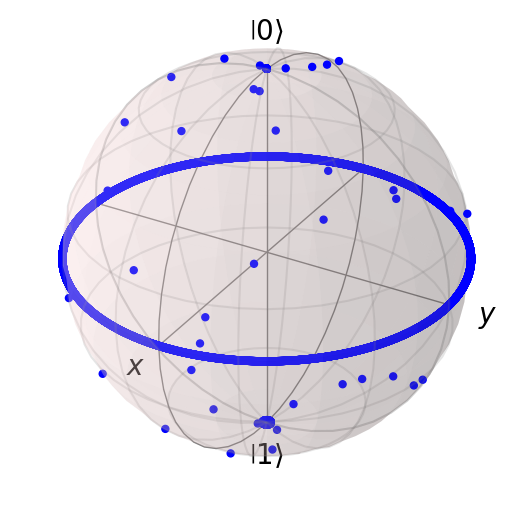

In [176]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

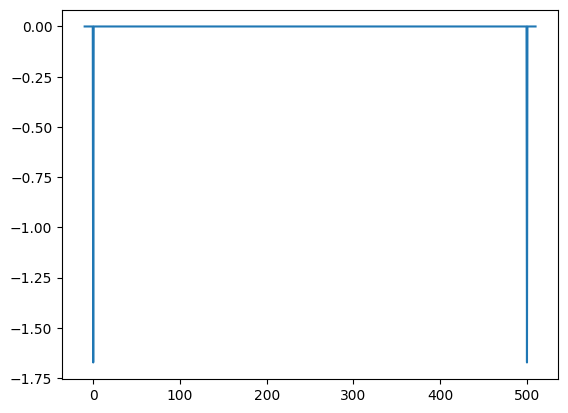

In [177]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*1

tlist = np.linspace(-10,510,1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [178]:
tlist = np.linspace(-10,510,10000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

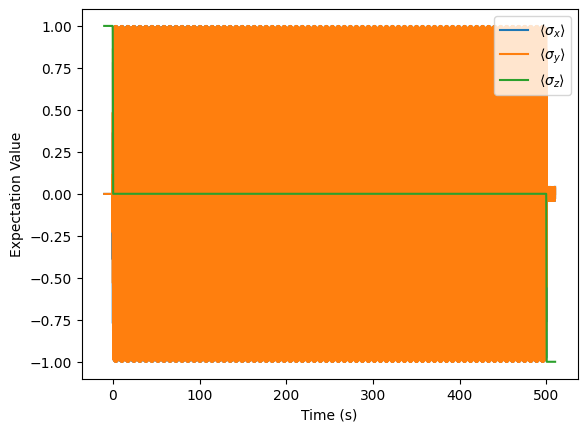

In [179]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

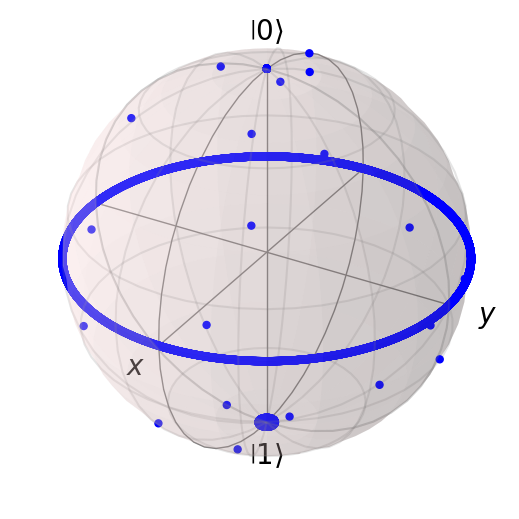

In [180]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

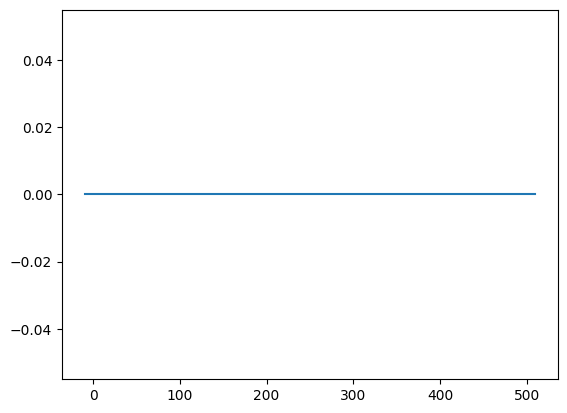

In [181]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*5
# Wrong Case

tlist = np.linspace(-10,510,1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*5, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [182]:
tlist = np.linspace(-10,510,10000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*5, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

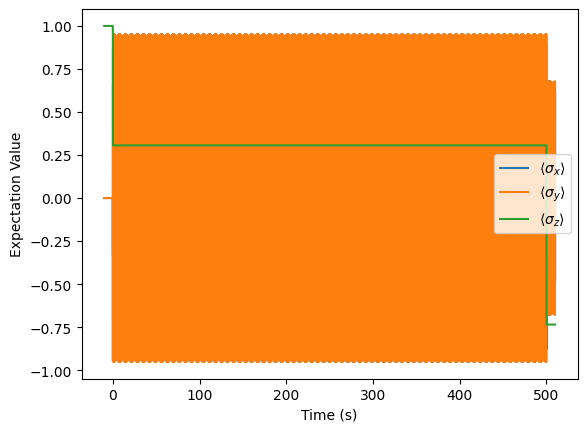

In [183]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

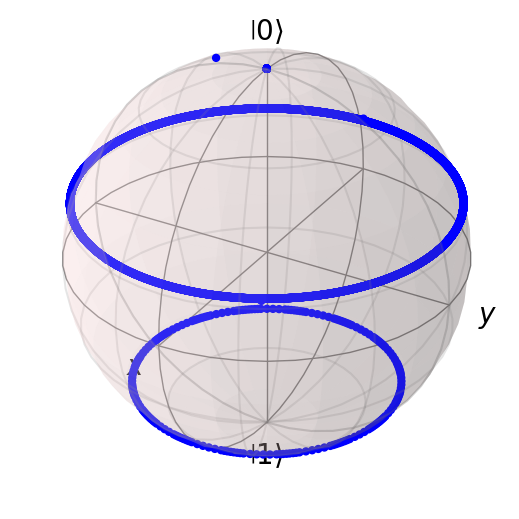

In [184]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

### 14) Ramsey

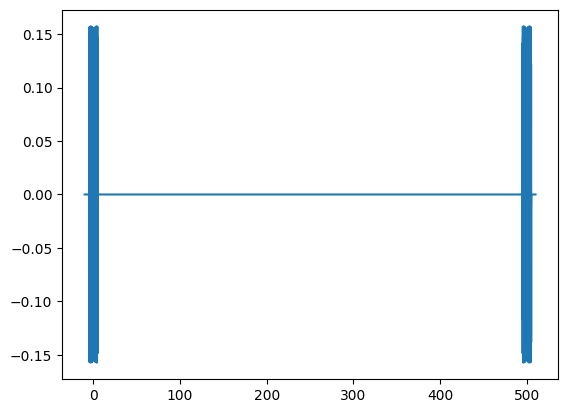

In [185]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.05

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0}))

In [186]:
tlist = np.linspace(-10,510,100000)

result0 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

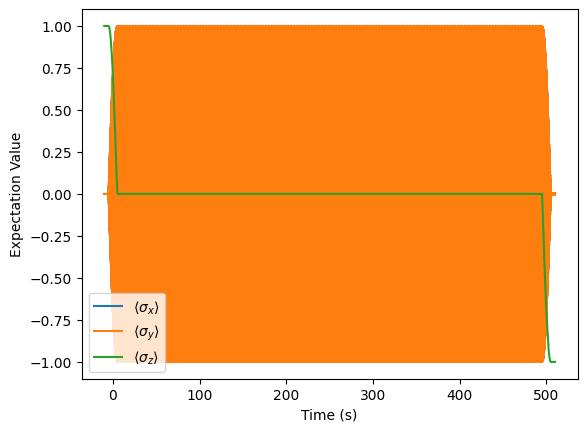

In [187]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

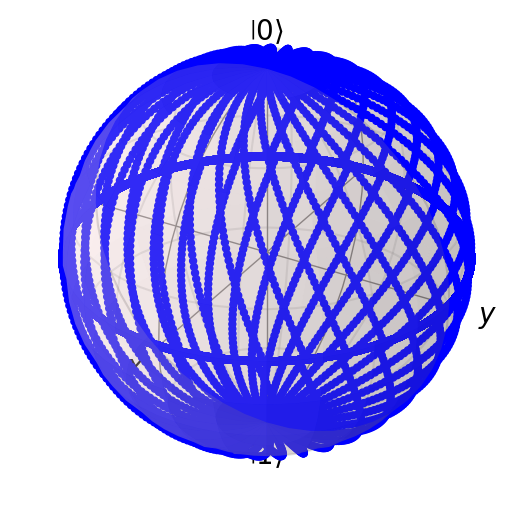

In [188]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

### 15) Spin Echo

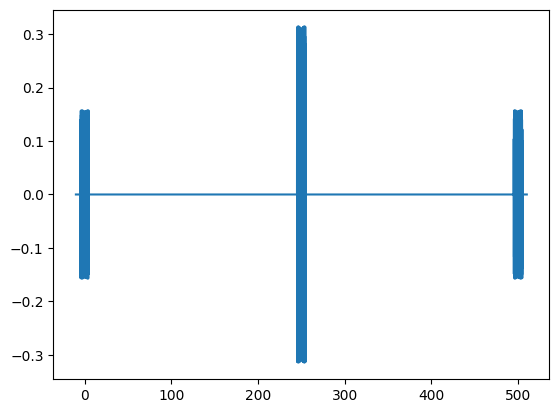

In [189]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.05

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 1, 'Env': 0, 'Func': 0}))

In [191]:
tlist = np.linspace(-10,510,100000)

result1 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

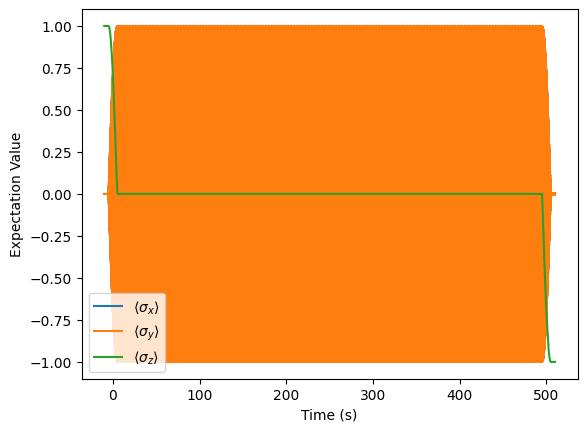

In [192]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result1.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result1.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result1.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

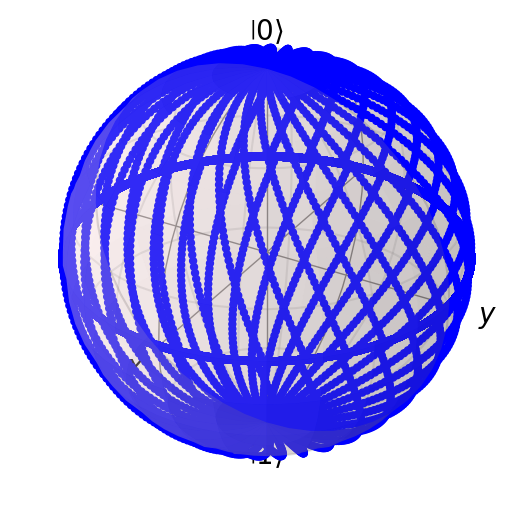

In [193]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result1.expect, meth="s")
sphere.show()

### 16) CP : N=2

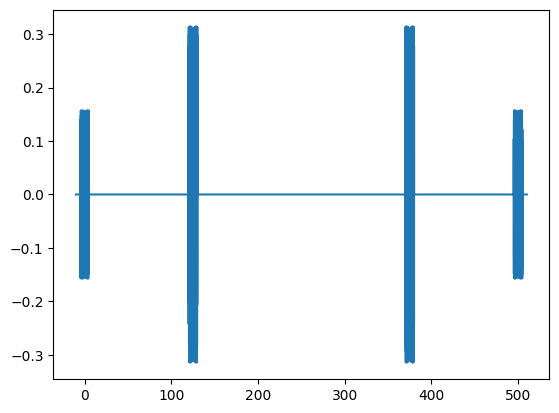

In [194]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.05

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 2, 'Env': 0, 'Func': 0}))

In [195]:
tlist = np.linspace(-10,510,100000)

resultCP2 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 2, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

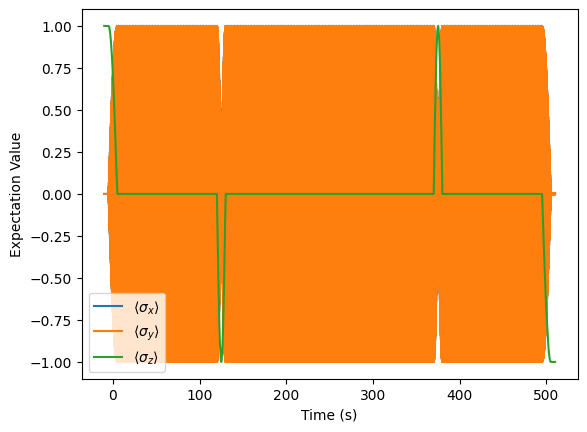

In [196]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, resultCP2.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, resultCP2.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, resultCP2.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

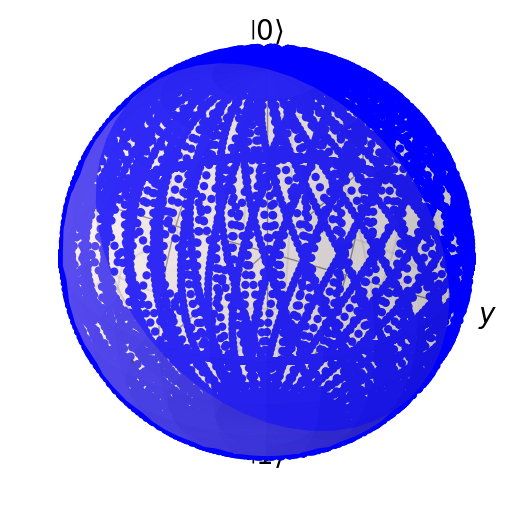

In [197]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(resultCP2.expect, meth="s")
sphere.show()

### 17) CP : N=4

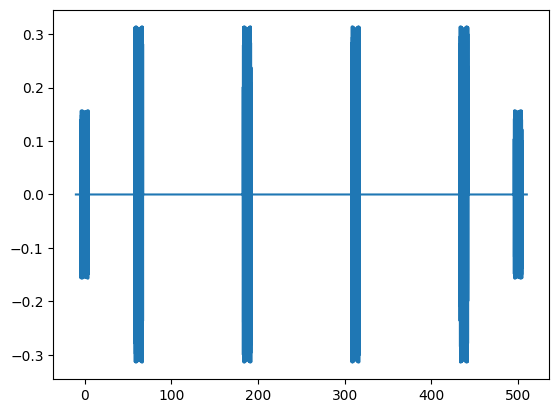

In [198]:
# Ramsey
# Square Pulse
# 'A': 2*np.pi*0.05

tlist = np.linspace(-10,510,10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 4, 'Env': 0, 'Func': 0}))

In [199]:
tlist = np.linspace(-10,510,100000)

resultCP4 = mesolve(
    [H0, [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 500, 'N': 4, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

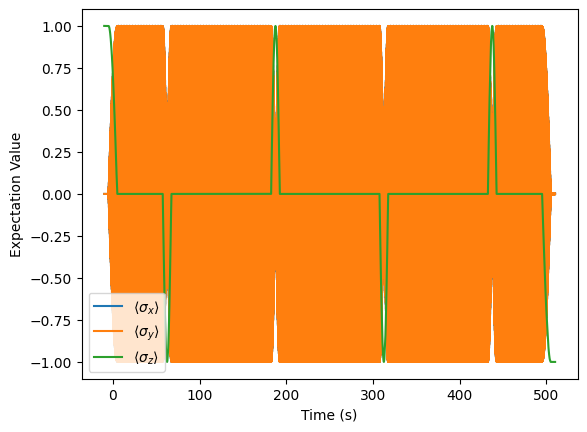

In [200]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, resultCP4.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, resultCP4.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, resultCP4.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

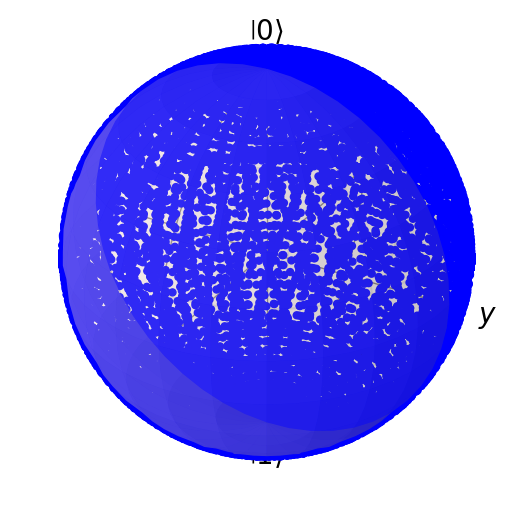

In [201]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(resultCP4.expect, meth="s")
sphere.show()

# 7. Free & Driven Evolution of Two-Level Systems

### 1) Pink Noise

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [52]:
def Chi_Ensemble (mu, sigma, num_seq):

  X = np.random.normal(mu, sigma, num_seq)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [53]:
def Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

  tlist = np.linspace(0, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  Chi_B = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)
  U_B = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]) + B * Chi_B[k] * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_B[k]))

  y = []
  for i in range(t_repeat):

    sum = 0
    for k in range(freq_repeat):
      sum = sum + lst[k][i]

    y.append(sum)

  Pink_Noise = np.array(y)

  return Pink_Noise

In [68]:
def Pink_Noise_Interpolate(t, min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

    Pink_Noise = Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)
    Pink_Noise_Continuous = scipy.interpolate.interp1d(t, Pink_Noise, fill_value="extrapolate")
    return Pink_Noise_Continuous

In [69]:
min_freq = 0.1
freq_repeat = 10000
t_repeat = 10000
t_end = 1

mu = 0
sigma = 0.01

A = 1
B = 0

In [70]:
tlist = np.linspace(0, t_end, t_repeat*10)
Pink_Noise = Pink_Noise_Interpolate(tlist, min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

UnboundLocalError: local variable 'Pink_Noise' referenced before assignment

### 2) Pink Noise Modularization